<a href="https://colab.research.google.com/github/seohyun126/ML_guide/blob/main/1117Surprise%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install surprise

In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

data=Dataset.load_builtin('ml-100k')
# 수행시마다 동일하게 데이터 분할하기 위해 random state 값 부여
trainset,testset=train_test_split(data,test_size=0.25,random_state=0)

In [ ]:
algo=SVD()
algo.fit(trainset)
# 학습된 추천 알고리즘 기반으로 추천 수행하기
predictions=algo.test(testset)
print('prediction type',type(predictions),'size',len(predictions))
print('prediction 결과 최초 5개 추출')
predictions[:5]

In [ ]:
# 객체에서 속성 추출하기
[(pred.uid,pred.iid,pred.est) for pred in predictions[:5]]

In [ ]:
#  개별 사용자의 아이템에 대한 추첨 평점 예측하기
# 사용자 아이디, 아이템 아이디는 문자열로 입력해야 함
uid=str(196)
iid=str(302)
pred=algo.predict(uid,iid)
print(pred)

In [ ]:
accuracy.rmse(predictions)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
ratings=pd.read_csv('/content/drive/MyDrive/ratings.csv')
ratings.to_csv('/content/drive/MyDrive/ratings_noh.csv',index=False,header=False)

In [ ]:
from surprise import Reader
reader=Reader(line_format='user item rating timestamp',sep=',',rating_scale=(0.5,5))
data=Dataset.load_from_file('/content/drive/MyDrive/ratings_noh.csv',reader=reader)

In [ ]:
# SVD 행렬 분해 기법을 이용해 추천 예측
# 잠재 요인 크기 k를 나타내느 파라미터인 n_factors를 50으로 설정해 데이터를 학습한 뒤 테스트 데이터 세트를 적용해
# 예측 평점 구하기
# 그리고 rmse로 평가하기
trainset,testset=train_test_split(data,test_size=0.25,random_state=0)
# 수행 시마다 동일한 결과를 나타내기 위해 random_state 적용
algo=SVD(n_factors=50,random_state=0)
# 학습 데이터 세트로 학습하고 나서 테스트 데이터 세트로 평점 예측후 rmse 평가
algo.fit(trainset)
predictions=algo.test(testset)
accuracy.rmse(predictions)

In [ ]:
# 판다스 데이터프레임에서 surprise 데이터 세트로 로딩
# 이때 주의할 점음 dataframe 역시 사용자 아이디 아이템 아이디 평점 칼럼순서를 지켜야 함
ratings = pd.read_csv('/content/drive/MyDrive/ratings.csv')
reader = Reader(rating_scale=(0.5, 5.0))


data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

algo = SVD(n_factors=50, random_state=0)
algo.fit(trainset)
predictions = algo.test( testset )
accuracy.rmse(predictions)


# SURPRISE 추천 알고리즘 클래스
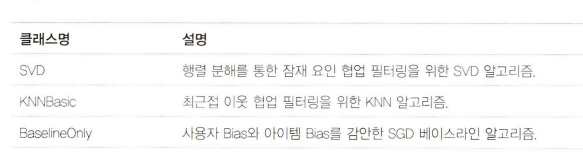

In [ ]:
# 교차검증과 하이퍼 파라미터 튜닝
from surprise.model_selection import cross_validate
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

algo = SVD(random_state=0)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
from surprise.model_selection import GridSearchCV

# 최적화할 파라미터들을 딕셔너리 형태로 지정.
param_grid = {'n_epochs': [20, 40, 60], 'n_factors': [50, 100, 200] }

# CV를 3개 폴드 세트로 지정, 성능 평가는 rmse, mse 로 수행 하도록 GridSearchCV 구성
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# 최고 RMSE Evaluation 점수와 그때의 하이퍼 파라미터
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

In [ ]:
# Surprise를 이용한 영화 추천 시스템 구축
from surprise.dataset import DatasetAutoFolds

reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5))
# DatasetAutoFolds 클래스를 ratings_noh.csv 파일 기반으로 생성.
data_folds = DatasetAutoFolds(ratings_file='/content/drive/MyDrive//ratings_noh.csv', reader=reader)

#전체 데이터를 학습데이터로 생성함.
trainset = data_folds.build_full_trainset()


algo = SVD(n_epochs=20, n_factors=50, random_state=0)
algo.fit(trainset)


# 영화에 대한 상세 속성 정보 DataFrame로딩
movies = pd.read_csv('/content/drive/MyDrive//movies.csv')

# userId=9 의 movieId 데이터 추출하여 movieId=42 데이터가 있는지 확인.
movieIds = ratings[ratings['userId']==9]['movieId']
if movieIds[movieIds==42].count() == 0:
    print('사용자 아이디 9는 영화 아이디 42의 평점 없음')

print(movies[movies['movieId']==42])

In [ ]:
uid=str(9)
iid=str(42)
pred=algo.predict(uid,iid,verbose=True)

In [ ]:
# 사용자가 평점을 매기지 않은 전체 영화를 추출한 뒤 예측 평점 순으로 영화 추천해보기
def get_unseen_surprise(ratings, movies, userId):
    #입력값으로 들어온 userId에 해당하는 사용자가 평점을 매긴 모든 영화를 리스트로 생성
    seen_movies = ratings[ratings['userId']== userId]['movieId'].tolist()

    # 모든 영화들의 movieId를 리스트로 생성.
    total_movies = movies['movieId'].tolist()

    # 모든 영화들의 movieId중 이미 평점을 매긴 영화의 movieId를 제외하여 리스트로 생성
    unseen_movies= [movie for movie in total_movies if movie not in seen_movies]
    print('평점 매긴 영화수:',len(seen_movies), '추천대상 영화수:',len(unseen_movies), \
          '전체 영화수:',len(total_movies))

    return unseen_movies

unseen_movies = get_unseen_surprise(ratings, movies, 9)

In [ ]:
# 추천 대상 영화 모두를 대상으로 추천 알고리즘 객체의 predict 매서드를 호출하고 그 결과인
# prediction 객체를 리스트 객체로 만들기
# 그리고 이렇게 저장된 리스트 내부의 prediction 객체를 예측 평점이 높은 순으로 다시 정렬한 뒤
# 객체에서 영화 아이디 영화 제목 예측 평점 정보 추출해 반환해보기
def recomm_movie_by_surprise(algo, userId, unseen_movies, top_n=10):
    # 알고리즘 객체의 predict() 메서드를 평점이 없는 영화에 반복 수행한 후 결과를 list 객체로 저장
    predictions = [algo.predict(str(userId), str(movieId)) for movieId in unseen_movies]

    # predictions list 객체는 surprise의 Predictions 객체를 원소로 가지고 있음.
    # [Prediction(uid='9', iid='1', est=3.69), Prediction(uid='9', iid='2', est=2.98),,,,]
    # 이를 est 값으로 정렬하기 위해서 아래의 sortkey_est 함수를 정의함.
    # sortkey_est 함수는 list 객체의 sort() 함수의 키 값으로 사용되어 정렬 수행.
    def sortkey_est(pred):
        return pred.est

    # sortkey_est( ) 반환값의 내림 차순으로 정렬 수행하고 top_n개의 최상위 값 추출.
    predictions.sort(key=sortkey_est, reverse=True)
    top_predictions= predictions[:top_n]

    # top_n으로 추출된 영화의 정보 추출. 영화 아이디, 추천 예상 평점, 제목 추출
    top_movie_ids = [ int(pred.iid) for pred in top_predictions]
    top_movie_rating = [ pred.est for pred in top_predictions]
    top_movie_titles = movies[movies.movieId.isin(top_movie_ids)]['title']
    top_movie_preds = [ (id, title, rating) for id, title, rating in zip(top_movie_ids, top_movie_titles, top_movie_rating)]

    return top_movie_preds

unseen_movies = get_unseen_surprise(ratings, movies, 9)
top_movie_preds = recomm_movie_by_surprise(algo, 9, unseen_movies, top_n=10)
print('##### Top-10 추천 영화 리스트 #####')

for top_movie in top_movie_preds:
    print(top_movie[1], ":", top_movie[2])